 # DSCOVR
[data source](https://www.spaceappschallenge.org/develop-the-oracle-of-dscovr-experimental-data-repository/)

The data files in this repository contain measurements from the DSCOVR PlasMAG instrument suite, recorded in the solar wind near the Earth-Sun L1 Lagrange Point between 2016 and the present day.

Each file corresponds to one year of measurements. The measurements themselves have been condensed and decimated to a cadence of one measurement set per minute.


|lines    | File name for a year 
|:-------:|:---------------------------------|
|   283680|dsc_fc_summed_spectra_2016_v01.csv|
|   525600|dsc_fc_summed_spectra_2017_v01.csv|
|   537120|dsc_fc_summed_spectra_2018_v01.csv|
|   256320|dsc_fc_summed_spectra_2019_v01.csv|
|   447840|dsc_fc_summed_spectra_2020_v01.csv|
|   525600|dsc_fc_summed_spectra_2021_v01.csv|
|   525600|dsc_fc_summed_spectra_2022_v01.csv|
|   175680|dsc_fc_summed_spectra_2023_v01.csv|


Total lines 3277440 with 54 columns. 

The `bash` command 

```bash
cat * >> sa_2016_2023_raw.csv
```

joins all data into one file.

The information we got from satellite is:


|column | Description|
|---------|:--------------------------|
|column 00| A date and time in Coordinated Universal Time (UTC), formatted like YYYY-MM-DD hh:mm:ss.|
|column 01| Components of the magnetic field vector that was measured at this time. They are expressed in units of nanoTesla (nT) and provided in the Geocentric Solar Ecliptic reference frame (GSE).
|column 02| Components of the magnetic field vector that was measured at this time. They are expressed in units of nanoTesla (nT) and provided in the Geocentric Solar Ecliptic reference frame (GSE).
|column 03| Components of the magnetic field vector that was measured at this time. They are expressed in units of nanoTesla (nT) and provided in the Geocentric Solar Ecliptic reference frame (GSE).
|column 04..53|A "raw" measurement spectrum from the Faraday cup plasma detector. Each value corresponds to the flux, or flow strength, of the solar wind in a particular range of energies (or flow speeds). These numbers are not calibrated or converted-- they are dimensionless numbers as encoded in the instrument computer.|



In [17]:
# **************************************************************************** #
#                                                                              #
#                                                         :::      ::::::::    #
#    ingest.py                                          :+:      :+:    :+:    #
#                                                     +:+ +:+         +:+      #
#    By: luicasad <luicasad@student.42.fr>          +#+  +:+       +#+         #
#                                                 +#+#+#+#+#+   +#+            #
#    Created: 2023/10/03 12:43:17 by luicasad          #+#    #+#              #
#    Updated: 2023/10/03 12:43:17 by luicasad         ###   ########.fr        #
#                                                                              #
# **************************************************************************** #

In [18]:
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [19]:
pd.set_option('display.max_columns', 55) 

In [20]:
def convert_zero_to_nan(value):
    if value == 0:
        return np.nan
    else:
        return value

def count_NAN(df):
    """
    Count NAN values in each column of a dataset.
    Print 5 counts in per line
    """
    col_counter = 0
    for col in df.columns:
        count = df[col].isna().sum()
        if ((col_counter % 5) == 0):
            sep = "|\n"
        else:
            sep = "| "
        print("|{} = {}".format(col,count), end=sep)
        col_counter = col_counter + 1

def sa_count_rows_per_day(sa, theyear):
    """
    filters sa DataFrame by year, grops rows by day and counts
    records per day.
    
    Returns x, y data for a scatter plot.
    x is the day of year (1....365/366)
    y is the number of records per day. 
    """
    year_rows = sa[sa['date'].dt.year == theyear]['date']
    day_of_year = year_rows.dt.dayofyear
    row_count_per_day = day_of_year.groupby(day_of_year).value_counts()
    return day_of_year.unique(),row_count_per_day.values

def	print_head_tail(df):
    print(df.iloc[[0,1, 2, df.index[-3],df.index[-2],df.index[-1]]])

In [28]:
# File path
os.chdir("../..")
home_dir = os.getcwd()
sa_data_folder =  home_dir +'/data/PlasMAG/'
sa_file_name = 'sa_2016_2023_raw.csv'
ou_file_name = 'satellite_data.csv'
sa_file_path = sa_data_folder + sa_file_name
ou_file_path = sa_data_folder + ou_file_name

In [29]:
# read data
sa = pd.read_csv(sa_file_path, delimiter = ',', parse_dates=[0],  header = None, na_values=['0'])

In [30]:
# set headers
columns = ["date", "MF_nT_GSE_x",  "MF_nT_GSE_y", "MF_nT_GSE_z"]
for i in range(4, 54):
	columns.append(f"C_{i:02d}")
sa.columns = columns

In [31]:
sa.describe()

,MF_nT_GSE_x,MF_nT_GSE_y,MF_nT_GSE_z,C_04,C_05,C_06,C_07,C_08,C_09,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,C_20,C_21,C_22,C_23,C_24,C_25,C_26,C_27,C_28,C_29,C_30,C_31,C_32,C_33,C_34,C_35,C_36,C_37,C_38,C_39,C_40,C_41,C_42,C_43,C_44,C_45,C_46,C_47,C_48,C_49,C_50,C_51,C_52,C_53
count,3.259998e+06,3.259998e+06,3.259998e+06,1.519804e+06,1.582311e+06,1.721032e+06,1.809991e+06,1.922099e+06,2.008476e+06,2.128636e+06,2.224303e+06,2.355847e+06,2.423554e+06,2.544506e+06,2.595041e+06,2.654082e+06,2.722756e+06,2.770479e+06,2.804984e+06,2.851611e+06,2.851943e+06,2.843002e+06,2.756084e+06,2.703525e+06,2.528038e+06,2.430453e+06,2.275570e+06,2.152931e+06,1.961822e+06,1.819571e+06,1.587118e+06,1.492596e+06,1.245140e+06,1.162693e+06,1.059190e+06,881042.000000,777816.000000,706546.000000,550896.000000,502344.000000,340977.000000,298253.000000,241819.000000,179435.000000,131650.000000,103457.000000,70114.000000,61407.000000,37701.000000,34288.000000,29597.000000,28458.000000,26270.000000
mean,8.015442e-02,-1.255092e-01,2.171055e-02,6.904954e+01,2.405151e+01,9.262740e+01,9.369958e+01,1.246801e+02,1.251655e+02,1.683491e+02,1.801567e+02,2.738568e+02,2.399177e+02,3.450860e+02,3.599229e+02,3.943654e+02,3.849338e+02,4.044870e+02,3.922045e+02,4.359357e+02,3.855633e+02,4.403939e+02,4.329426e+02,4.073135e+02,4.265644e+02,4.308881e+02,4.099598e+02,4.444366e+02,3.932879e+02,4.423821e+02,4.349725e+02,4.049480e+02,4.159556e+02,4.110927e+02,3.801180e+02,414.636939,352.416403,405.427138,394.848851,416.561870,387.194332,388.968071,367.096545,410.258331,353.559684,397.477883,381.584273,351.028206,364.846009,364.814574,339.140779,387.293616,339.150626
std,3.410268e+00,3.765791e+00,2.982616e+00,6.505515e+01,4.948382e+01,7.784311e+01,8.532521e+01,1.040021e+02,1.253738e+02,1.497272e+02,1.710773e+02,1.649719e+02,1.906709e+02,1.630900e+02,1.622416e+02,1.485736e+02,1.509792e+02,1.342895e+02,1.315634e+02,1.018971e+02,1.164100e+02,8.689607e+01,8.536814e+01,9.047039e+01,8.192362e+01,7.937772e+01,8.742738e+01,7.588670e+01,9.696973e+01,8.007255e+01,8.541684e+01,9.530124e+01,9.510656e+01,9.297082e+01,9.996148e+01,87.272946,102.840236,79.261283,80.637011,71.751503,79.146963,72.969746,67.597888,66.313573,66.450856,72.205229,84.113211,85.454188,99.350766,104.976669,109.746891,118.891957,112.803118
min,-2.014280e+01,-3.178510e+01,-3.332440e+01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,7.151910e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.317260e-01,2.198770,0.231726,0.346956,0.231726,0.231726,0.231726,1.893860,0.309239,96.621000,63.826300,63.398300,2.675280,2.947210,59.301300,76.164100,65.362400,0.231726,2.469710
25%,-2.532720e+00,-2.640140e+00,-1.522248e+00,3.139748e+01,2.317260e-01,4.230860e+01,3.983035e+01,5.333525e+01,4.449867e+01,6.975355e+01,6.776705e+01,1.619150e+02,1.214153e+02,2.545670e+02,2.755930e+02,3.258470e+02,3.150290e+02,3.435040e+02,3.314650e+02,3.902510e+02,3.289705e+02,3.981380e+02,3.889907e+02,3.569310e+02,3.789420e+02,3.832400e+02,3.523910e+02,3.963310e+02,3.264130e+02,3.895940e+02,3.787180e+02,3.373300e+02,3.515300e+02,3.462700e+02,3.098460e+02,357.528000,283.695750,358.590000,349.425750,380.871000,347.289000,358.022000,339.578000,392.940000,336.209750,387.257000,372.588500,339.152500,365.221000,370.332750,341.495000,397.712750,343.118500
50%,1.694915e-01,-2.131885e-01,3.084400e-02,5.893845e+01,1.063320e+01,8.518255e+01,8.183820e+01,1.085690e+02,1.006845e+02,1.356920e+02,1.384980e+02,2.542390e+02,1.977120e+02,3.303730e+02,3.438670e+02,3.799520e+02,3.660110e+02,3.847070e+02,3.676980e+02,4.185550e+02,3.616780e+02,4.242270e+02,4.169460e+02,3.893620e+02,4.122220e+02,4.156920e+02,3.944290e+02,4.304150e+02,3.763560e+02,4.298310e+02,4.215680e+02,3.8971

#### Missing days and duplicated measures

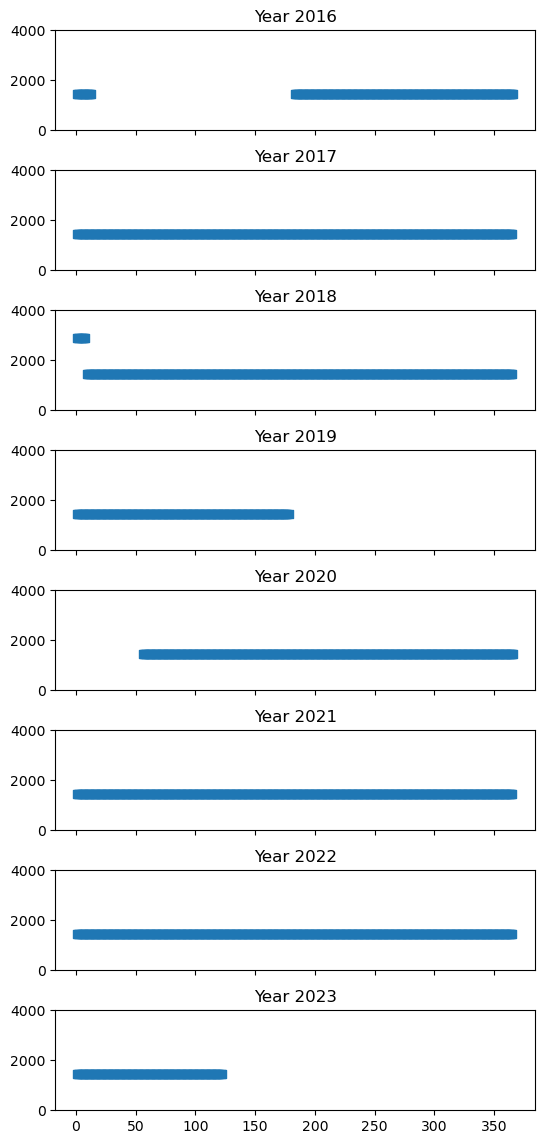

In [32]:
years =[2016,2017,2018,2019,2020,2021,2022,2023]
fig, axis = plt.subplots(len(years), sharex=True, sharey=True, figsize = (6, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.9, 
                    wspace=0.4, 
                    hspace=0.4)

for index, year in enumerate(years):
    x, y = sa_count_rows_per_day(sa, year)
    axis[index].scatter(x, y , marker = ",")
    axis[index].set_title("Year " + str(year))
    axis[index].set_ylim(0, 4000)
 

There are no satellite data in 3 periods

|From       | to     |
|-----------|--------|
|14-01-2016|30-06-2021|
|28-06-2019|24-02-2020|
|03-05-2023|31-08-2023|

This is the equivalent of  4256 3-hour intervals from Kp file.

Additionally we can appreciate that in January 2018, during 8 days there are 120 records per hour. These records are in rows 809282 .. 820802. 

820802 minus 809282 = 11520 records divided by 1440 recors/day = 8 days

In [10]:
count_NAN(sa)

|date = 0|
|MF_nT_GSE_x = 17442| |MF_nT_GSE_y = 17442| |MF_nT_GSE_z = 17442| |C_04 = 1757636| |C_05 = 1695129|
|C_06 = 1556408| |C_07 = 1467449| |C_08 = 1355341| |C_09 = 1268964| |C_10 = 1148804|
|C_11 = 1053137| |C_12 = 921593| |C_13 = 853886| |C_14 = 732934| |C_15 = 682399|
|C_16 = 623358| |C_17 = 554684| |C_18 = 506961| |C_19 = 472456| |C_20 = 425829|
|C_21 = 425497| |C_22 = 434438| |C_23 = 521356| |C_24 = 573915| |C_25 = 749402|
|C_26 = 846987| |C_27 = 1001870| |C_28 = 1124509| |C_29 = 1315618| |C_30 = 1457869|
|C_31 = 1690322| |C_32 = 1784844| |C_33 = 2032300| |C_34 = 2114747| |C_35 = 2218250|
|C_36 = 2396398| |C_37 = 2499624| |C_38 = 2570894| |C_39 = 2726544| |C_40 = 2775096|
|C_41 = 2936463| |C_42 = 2979187| |C_43 = 3035621| |C_44 = 3098005| |C_45 = 3145790|
|C_46 = 3173983| |C_47 = 3207326| |C_48 = 3216033| |C_49 = 3239739| |C_50 = 3243152|
|C_51 = 3247843| |C_52 = 3248982| |C_53 = 3251170| 

In total, there are 89 413 068 NaN values in a data set of 3 277 439 x 53 = 173 704 267 data points. A 51,47% of Satellite dataset data points are NaN values, ergo zeroes. Maybe I have to think about a sparse matrix.

In [11]:
#Normaliza
integer_columns = columns[1:4]
natural_columns = columns[4:] 
integer_scaler = MinMaxScaler(feature_range=(-1, 1))
natural_scaler = MinMaxScaler(feature_range=( 0, 1))
sa[integer_columns] = integer_scaler.fit_transform(sa[integer_columns])
sa[natural_columns] = natural_scaler.fit_transform(sa[natural_columns])
print_head_tail(sa)

                       date  MF_nT_GSE_x  MF_nT_GSE_y  MF_nT_GSE_z      C_04  \
0       2016-01-01 00:00:00     0.014393    -0.048047    -0.401312       NaN   
1       2016-01-01 00:01:00     0.011807    -0.045453    -0.403548       NaN   
2       2016-01-01 00:02:00    -0.002340    -0.022322    -0.413243       NaN   
3277437 2023-05-02 23:57:00    -0.081594     0.166464     0.005021  0.000372   
3277438 2023-05-02 23:58:00    -0.080446     0.154926     0.028362  0.000340   
3277439 2023-05-02 23:59:00    -0.072863     0.142389     0.031569  0.001214   

         C_05      C_06      C_07      C_08      C_09      C_10      C_11  \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3277437   0.0  0.004536  0.001199  0.002347  0.000000  0.000931  0.000188   
3277438   0.0  0.007219  0.001729  0.002702  0.000038 

In [12]:
# Nan Substituion
sa.fillna(0, inplace=True)
print_head_tail(sa)

                       date  MF_nT_GSE_x  MF_nT_GSE_y  MF_nT_GSE_z      C_04  \
0       2016-01-01 00:00:00     0.014393    -0.048047    -0.401312  0.000000   
1       2016-01-01 00:01:00     0.011807    -0.045453    -0.403548  0.000000   
2       2016-01-01 00:02:00    -0.002340    -0.022322    -0.413243  0.000000   
3277437 2023-05-02 23:57:00    -0.081594     0.166464     0.005021  0.000372   
3277438 2023-05-02 23:58:00    -0.080446     0.154926     0.028362  0.000340   
3277439 2023-05-02 23:59:00    -0.072863     0.142389     0.031569  0.001214   

         C_05      C_06      C_07      C_08      C_09      C_10      C_11  \
0         0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1         0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2         0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3277437   0.0  0.004536  0.001199  0.002347  0.000000  0.000931  0.000188   
3277438   0.0  0.007219  0.001729  0.002702  0.000038 

In [13]:
'dense : {:0.2f} Mbytes'.format(sa.memory_usage().sum()/1024/1024)


'dense : 1350.26 Mbytes'

In [14]:
sa.describe()

,MF_nT_GSE_x,MF_nT_GSE_y,MF_nT_GSE_z,C_04,C_05,C_06,C_07,C_08,C_09,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,C_20,C_21,C_22,C_23,C_24,C_25,C_26,C_27,C_28,C_29,C_30,C_31,C_32,C_33,C_34,C_35,C_36,C_37,C_38,C_39,C_40,C_41,C_42,C_43,C_44,C_45,C_46,C_47,C_48,C_49,C_50,C_51,C_52,C_53
count,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06,3.277440e+06
mean,-2.383518e-01,6.067318e-02,-2.144970e-02,1.904592e-02,7.266987e-03,2.795127e-02,3.449597e-02,4.295583e-02,4.142438e-02,4.809271e-02,4.141594e-02,8.029120e-02,7.703560e-02,1.120477e-01,9.290088e-02,1.092236e-01,9.481449e-02,1.252500e-01,1.029338e-01,1.169694e-01,5.879512e-02,7.704338e-02,8.393935e-02,8.438015e-02,1.044167e-01,1.291067e-01,1.093195e-01,1.355406e-01,6.666566e-02,9.303589e-02,3.224292e-02,4.598871e-02,6.885284e-02,7.647043e-02,6.306032e-02,5.564253e-02,3.374870e-02,3.327270e-02,2.495886e-02,2.988043e-02,2.100341e-02,1.612704e-02,1.597123e-02,1.034253e-02,6.871797e-03,6.157846e-03,4.605992e-03,3.867295e-03,2.117556e-03,1.621065e-03,1.383234e-03,1.792631e-03,1.447384e-03
std,1.290657e-01,1.259437e-01,8.729630e-02,3.344503e-02,2.299217e-02,4.198327e-02,5.253983e-02,5.914825e-02,6.248254e-02,6.381946e-02,5.565147e-02,7.603951e-02,8.467313e-02,8.504762e-02,6.698641e-02,6.996649e-02,5.914497e-02,7.013210e-02,5.638546e-02,5.388100e-02,2.963638e-02,3.425956e-02,4.073008e-02,4.402026e-02,6.126931e-02,8.107059e-02,7.775132e-02,1.020383e-01,5.858585e-02,8.629895e-02,3.449757e-02,5.278803e-02,9.160139e-02,1.071452e-01,9.581307e-02,9.453538e-02,6.379248e-02,6.499919e-02,5.690241e-02,7.145159e-02,6.305926e-02,5.195640e-02,5.761526e-02,4.397933e-02,3.449932e-02,3.492051e-02,3.192717e-02,2.883383e-02,2.065279e-02,1.678627e-02,1.562069e-02,2.004490e-02,1.698838e-02
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-3.373844e-01,-2.285498e-02,-6.655517e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.259275e-02,4.463596e-02,7.103409e-02,6.944679e-02,1.077734e-01,9.106599e-02,1.146927e-01,5.442155e-02,7.761612e-02,8.566403e-02,8.412381e-02,1.065337e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-2.351356e-01,5.712253e-02,-2.088127e-02,0.000000e+00,0.000000e+00,1.666142e-04,2.607747e-03,1.869013e-02,1.740181e-02,2.723031e-02,2.466333e-02,7.580692e-02,6.248848e-02,1.223587e-01,1.022209e-01,1.231952e-01,1.039493e-01,1.366752e-

In [15]:
#Save data
sa.to_csv(ou_file_path, index=False)